In [7]:
from eve import Eve
from eve_plus import EvePlus
from models import *


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from utils import lr_down_linearly, lr_down_cyclically
from utils import lr_up_linearly


%reload_ext autoreload
%autoreload 2


In [ ]:
### pytorch cifar

In [8]:
# variables
batch_size = 128
cuda = torch.cuda.is_available()


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# load data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)





Files already downloaded and verified
Files already downloaded and verified


In [128]:
def train(epoch, model, optimizer):
    model.train()
    total_loss = 0
    total_d_t = []
    total_lost_list = []
    train_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if epoch < 39:
            optimizer = lr_down_linearly(optimizer, epoch, batch_idx)
        else:
            optimizer = lr_down_cyclically(optimizer, epoch, batch_idx)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        def closure():
            optimizer.zero_grad()  # reset reset optimizer
            output = model(data)
            loss = F.cross_entropy(output, target)  # negative log likelihood loss
            loss.backward()  # backprop
            return loss, output

        loss, d_t, output = optimizer.step(closure)
        loss_value = loss.data[0]
        total_loss += loss_value / len(train_loader)
        total_lost_list.append(loss_value)
        total_d_t.append(d_t)
        pred = output.data.max(1)[1]
        train_correct += pred.eq(target.data).cpu().sum()
        if batch_idx % 20 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:>4.2%})] Loss: {:>5.3} Accuracy: {} lr: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                batch_idx / len(train_loader), total_loss, train_correct / len(train_loader.dataset), optimizer.param_groups[0]['lr'], ),
                end="")
    return total_loss, total_d_t, total_lost_list


def test(epoch, model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)  # loss function already averages over batch size
    test_accuracy = correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2%})'.format(
        test_loss, correct, len(test_loader.dataset),
        correct / len(test_loader.dataset)))
    return test_loss, test_accuracy


In [ ]:
import time
print ('EVE')
eve_loss = []
eve_loss_list = []
eve_test_loss = []
eve_test_acc = []
eve_dt = []
torch.manual_seed(233)
model = VGG('VGG16')
# net = ResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = DPN92()
# net = ShuffleNetG2()
if cuda:
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
optimizer = EvePlus(model.parameters(), lr=0.001)
epochs = 50
a = time.time()
for i in range(1, epochs + 1):
    train_loss, dt, loss_list = train(i, model, optimizer)
    eve_loss.append(train_loss)
    eve_dt += dt
    eve_loss_list += loss_list
    test_loss, test_accuracy = test(i, model)
    eve_test_loss.append(test_loss)
    eve_test_acc.append(test_accuracy)
b = time.time()
print (b-a)

EVE
Train Epoch: 1 [48640/50000 (97.19%)] Loss:  1.54 Accuracy: 0.3823 lr: 0.00096329833349388397
Test set: Average loss: 1.6101, Accuracy: 4450/10000 (44.50%)
Train Epoch: 2 [48640/50000 (97.19%)] Loss:  1.04 Accuracy: 0.60268 lr: 0.0009291953168556031
Test set: Average loss: 1.1882, Accuracy: 6092/10000 (60.92%)
Train Epoch: 3 [48640/50000 (97.19%)] Loss:  0.84 Accuracy: 0.68282 lr: 0.0008974243919949744
Test set: Average loss: 1.1800, Accuracy: 6308/10000 (63.08%)
Train Epoch: 4 [48640/50000 (97.19%)] Loss:  0.72 Accuracy: 0.7294 lr: 0.00086775425199583482
Test set: Average loss: 0.6898, Accuracy: 7727/10000 (77.27%)
Train Epoch: 5 [48640/50000 (97.19%)] Loss:  0.61 Accuracy: 0.77054 lr: 0.0008399832003359932
Test set: Average loss: 0.7379, Accuracy: 7569/10000 (75.69%)
Train Epoch: 6 [48640/50000 (97.19%)] Loss: 0.531 Accuracy: 0.79938 lr: 0.0008139345596614033
Test set: Average loss: 0.5677, Accuracy: 8100/10000 (81.00%)
Train Epoch: 7 [48640/50000 (97.19%)] Loss: 0.477 Accuracy: 

In [142]:
epochs = 65
a = time.time()
for i in range(57, epochs + 1):
    train_loss, dt, loss_list = train(i, model, optimizer)
    eve_loss.append(train_loss)
    eve_dt += dt
    eve_loss_list += loss_list
    test_loss, test_accuracy = test(i, model)
    eve_test_loss.append(test_loss)
    eve_test_acc.append(test_accuracy)
b = time.time()
print (b-a)

Train Epoch: 57 [48640/50000 (97.19%)] Loss: 0.0796 Accuracy: 0.94796 lr: 0.0015383631696600001
Test set: Average loss: 0.3858, Accuracy: 9046/10000 (90.46%)
Train Epoch: 58 [48640/50000 (97.19%)] Loss: 0.0386 Accuracy: 0.96216 lr: 3.836316966000005e-058
Test set: Average loss: 0.3590, Accuracy: 9179/10000 (91.79%)
Train Epoch: 59 [48640/50000 (97.19%)] Loss: 0.0805 Accuracy: 0.94818 lr: 0.0015383631696600012
Test set: Average loss: 0.4059, Accuracy: 9051/10000 (90.51%)
Train Epoch: 60 [48640/50000 (97.19%)] Loss: 0.0365 Accuracy: 0.96258 lr: 3.836316966000005e-058
Test set: Average loss: 0.3725, Accuracy: 9149/10000 (91.49%)
Train Epoch: 61 [48640/50000 (97.19%)] Loss: 0.0741 Accuracy: 0.9503 lr: 0.00153836316966600001
Test set: Average loss: 0.3655, Accuracy: 9070/10000 (90.70%)
Train Epoch: 62 [48640/50000 (97.19%)] Loss: 0.033 Accuracy: 0.964 lr: 3.836316966000005e-050008
Test set: Average loss: 0.3553, Accuracy: 9172/10000 (91.72%)
Train Epoch: 63 [48640/50000 (97.19%)] Loss: 0.07

In [87]:
len(eve_test_acc)

48

vgg19 1epoch 107s
google net 1epoch 106s
105.70495510101318
2748.2364859580994


### adam

In [9]:
def train(epoch, model, optimizer):
    model.train()
    total_loss = 0
    total_loss_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer = lr_down_linearly(optimizer, epoch, batch_idx)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        def closure():
            optimizer.zero_grad()  # reset reset optimizer
            output = model(data)
            loss = F.cross_entropy(output, target)  # negative log likelihood loss
            loss.backward()  # backprop
            return loss

        loss = optimizer.step(closure)
        loss_value = loss.data[0]
        total_loss +=  loss_value/ len(train_loader)
        total_loss_list.append(loss_value)
        if batch_idx % 20 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:>4.2%})] Loss: {:>5.3}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       batch_idx / len(train_loader), total_loss),
                end="")
    return total_loss, total_loss_list


def test(epoch, model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)  # loss function already averages over batch size
    test_accuracy = correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2%})'.format(
        test_loss, correct, len(test_loader.dataset),
        correct / len(test_loader.dataset)))
    return test_loss, test_accuracy

In [40]:
print("Adam")
adam_loss = []
adam_loss_list = []
adam_test_loss = []
adam_test_acc = []
torch.manual_seed(233)
model = VGG('VGG16')
if cuda:
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
optimizer = optim.Adam(model.parameters(), lr=0.01)
epoch = 56
for i in range(51, epochs + 1):
    total_loss, total_loss_list = train(i, model, optimizer)
    adam_loss.append(total_loss)
    adam_loss_list += total_loss_list
    test_loss, test_acc = test(i, model)
    adam_test_loss.append(test_loss)
    adam_test_acc.append(test_acc)


# plot(eve_loss, adam_loss, "eve_loss.png", "training loss")
# plot(eve_test_loss, adam_test_loss, "eve_test_loss.png", "testing loss")

Adam
Train Epoch: 1 [48640/50000 (97.19%)] Loss:  1.61
Test set: Average loss: 1.3166, Accuracy: 5155/10000 (51.55%)
Train Epoch: 2 [48640/50000 (97.19%)] Loss:  1.05
Test set: Average loss: 1.1264, Accuracy: 6122/10000 (61.22%)
Train Epoch: 3 [48640/50000 (97.19%)] Loss: 0.834
Test set: Average loss: 0.9142, Accuracy: 6859/10000 (68.59%)
Train Epoch: 4 [48640/50000 (97.19%)] Loss: 0.702
Test set: Average loss: 0.6652, Accuracy: 7738/10000 (77.38%)
Train Epoch: 5 [48640/50000 (97.19%)] Loss: 0.611
Test set: Average loss: 0.6602, Accuracy: 7831/10000 (78.31%)
Train Epoch: 6 [48640/50000 (97.19%)] Loss: 0.543
Test set: Average loss: 0.5274, Accuracy: 8214/10000 (82.14%)
Train Epoch: 7 [48640/50000 (97.19%)] Loss: 0.487
Test set: Average loss: 0.5648, Accuracy: 8149/10000 (81.49%)
Train Epoch: 8 [48640/50000 (97.19%)] Loss: 0.4399
Test set: Average loss: 0.4758, Accuracy: 8416/10000 (84.16%)
Train Epoch: 9 [48640/50000 (97.19%)] Loss: 0.4026
Test set: Average loss: 0.4527, Accuracy: 8511/

In [ ]:
print("Rms")
rms_loss = []
rms_loss_list = []
rms_test_loss = []
rms_test_acc = []
torch.manual_seed(233)
model = VGG('VGG16')
if cuda:
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
epochs = 50
for i in range(1, epochs + 1):
    total_loss, total_loss_list = train(i, model, optimizer)
    rms_loss.append(total_loss)
    rms_loss_list += total_loss_list
    test_loss, test_acc = test(i, model)
    rms_test_loss.append(test_loss)
    rms_test_acc.append(test_acc)


# plot(eve_loss, adam_loss, "eve_loss.png", "training loss")
# plot(eve_test_loss, adam_test_loss, "eve_test_loss.png", "testing loss")

Rms
Train Epoch: 1 [48640/50000 (97.19%)] Loss:  2.23
Test set: Average loss: 2.0992, Accuracy: 2119/10000 (21.19%)
Train Epoch: 2 [48640/50000 (97.19%)] Loss:  1.77
Test set: Average loss: 1.6958, Accuracy: 3622/10000 (36.22%)
Train Epoch: 3 [48640/50000 (97.19%)] Loss:  1.43
Test set: Average loss: 1.9162, Accuracy: 3466/10000 (34.66%)
Train Epoch: 4 [48640/50000 (97.19%)] Loss:  1.11
Test set: Average loss: 1.0390, Accuracy: 6209/10000 (62.09%)
Train Epoch: 5 [48640/50000 (97.19%)] Loss: 0.876
Test set: Average loss: 1.0477, Accuracy: 6657/10000 (66.57%)
Train Epoch: 19 [48640/50000 (97.19%)] Loss: 0.302
Test set: Average loss: 0.6301, Accuracy: 8257/10000 (82.57%)
Train Epoch: 20 [25600/50000 (51.15%)] Loss: 0.1581

Process Process-77:
KeyboardInterrupt
Process Process-78:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 341, in ge

KeyboardInterrupt: 

In [ ]:
1+2

In [144]:
print("ada")
ada_loss = []
ada_test_loss = []
ada_test_acc = []
torch.manual_seed(233)
model = Net()
if cuda:
    model.cuda()
optimizer = optim.Adagrad(model.parameters(), lr=0.1)
epoch = 50
for i in range(1, epochs + 1):
    ada_loss.append(train(i, model, optimizer))
    test_loss, test_acc = test(i, model)
    ada_test_loss.append(test_loss)
    ada_test_acc.append(test_acc)


# plot(eve_loss, adam_loss, "eve_loss.png", "training loss")
# plot(eve_test_loss, adam_test_loss, "eve_test_loss.png", "testing loss")

ada
Train Epoch: 1 [48640/50000 (97.19%)] Loss:  1.64
Test set: Average loss: 1.5024, Accuracy: 4690/10000 (46.90%)
Train Epoch: 2 [48640/50000 (97.19%)] Loss:  1.15
Test set: Average loss: 1.1309, Accuracy: 6068/10000 (60.68%)
Train Epoch: 3 [48640/50000 (97.19%)] Loss: 0.936
Test set: Average loss: 1.0463, Accuracy: 6336/10000 (63.36%)
Train Epoch: 4 [48640/50000 (97.19%)] Loss: 0.802
Test set: Average loss: 0.9678, Accuracy: 6673/10000 (66.73%)
Train Epoch: 5 [48640/50000 (97.19%)] Loss:   0.7
Test set: Average loss: 0.9455, Accuracy: 6807/10000 (68.07%)
Train Epoch: 6 [48640/50000 (97.19%)] Loss: 0.619
Test set: Average loss: 0.8017, Accuracy: 7203/10000 (72.03%)
Train Epoch: 7 [48640/50000 (97.19%)] Loss: 0.547
Test set: Average loss: 0.8209, Accuracy: 7287/10000 (72.87%)
Train Epoch: 8 [48640/50000 (97.19%)] Loss: 0.486
Test set: Average loss: 0.8267, Accuracy: 7244/10000 (72.44%)
Train Epoch: 9 [48640/50000 (97.19%)] Loss:  0.434
Test set: Average loss: 0.8019, Accuracy: 7375/10

KeyboardInterrupt: 

In [8]:
# print("Eve")
# eve_loss = []
# eve_test_loss = []

torch.manual_seed(23)


model_1 = Net()
model_1.cuda()
model_1.conv1.weight





# if cuda:
#     model.cuda()
# optimizer = Eve(model.parameters())
# for i in range(1, epochs + 1):
#     eve_loss.append(train(i, model, optimizer))
#     eve_test_loss.append(test(i, model))

# print("Adam")
# adam_loss = []
# adam_test_loss = []
# model = Net()
# if cuda:
#     model.cuda()
# optimizer = optim.Adam(model.parameters())
# for i in range(1, epochs + 1):
#     adam_loss.append(train(i, model, optimizer))
#     adam_test_loss.append(test(i, model))

# plot(eve_loss)
# plot(eve_test_loss, adam_test_loss, "eve_test_loss.png", "testing loss")

Parameter containing:
(0 ,0 ,.,.) = 
  0.0067  0.0651  0.1720
 -0.1212  0.1022  0.1084
 -0.0838  0.0284 -0.1074

(0 ,1 ,.,.) = 
 -0.0224  0.0717 -0.1216
 -0.1281 -0.1540 -0.0414
 -0.1079  0.0454  0.1283

(0 ,2 ,.,.) = 
 -0.0339 -0.0282 -0.1915
  0.0980  0.1478  0.1912
  0.1482 -0.1924 -0.0768

(1 ,0 ,.,.) = 
  0.1832  0.0345 -0.0311
  0.1841  0.0699  0.1328
  0.0972 -0.1674  0.0304

(1 ,1 ,.,.) = 
 -0.0790 -0.0404 -0.0816
 -0.0079  0.1241 -0.0420
  0.0486  0.0643 -0.1499

(1 ,2 ,.,.) = 
  0.0986 -0.1922  0.1284
  0.1702 -0.1262 -0.1380
 -0.1108 -0.0302  0.1442

(2 ,0 ,.,.) = 
 -0.0591 -0.0259  0.1423
  0.1448 -0.0275 -0.0113
  0.1265 -0.0760  0.0839

(2 ,1 ,.,.) = 
  0.1029 -0.1466 -0.1885
  0.0371  0.0678 -0.1425
 -0.0109 -0.1626  0.0516

(2 ,2 ,.,.) = 
  0.1275  0.1618 -0.0137
 -0.1418 -0.1301  0.1306
  0.0185  0.0789  0.0341

(3 ,0 ,.,.) = 
  0.1801  0.1053  0.1556
  0.0600 -0.0797  0.0222
 -0.1357 -0.1238 -0.1381

(3 ,1 ,.,.) = 
 -0.0998  0.1749  0.0023
 -0.1923 -0.0397 -0.0806
 -0

In [15]:
model_2 = Net()
model_2.cuda()
model_2.conv1.weight

Parameter containing:
(0 ,0 ,.,.) = 
  0.0067  0.0651  0.1720
 -0.1212  0.1022  0.1084
 -0.0838  0.0284 -0.1074

(0 ,1 ,.,.) = 
 -0.0224  0.0717 -0.1216
 -0.1281 -0.1540 -0.0414
 -0.1079  0.0454  0.1283

(0 ,2 ,.,.) = 
 -0.0339 -0.0282 -0.1915
  0.0980  0.1478  0.1912
  0.1482 -0.1924 -0.0768

(1 ,0 ,.,.) = 
  0.1832  0.0345 -0.0311
  0.1841  0.0699  0.1328
  0.0972 -0.1674  0.0304

(1 ,1 ,.,.) = 
 -0.0790 -0.0404 -0.0816
 -0.0079  0.1241 -0.0420
  0.0486  0.0643 -0.1499

(1 ,2 ,.,.) = 
  0.0986 -0.1922  0.1284
  0.1702 -0.1262 -0.1380
 -0.1108 -0.0302  0.1442

(2 ,0 ,.,.) = 
 -0.0591 -0.0259  0.1423
  0.1448 -0.0275 -0.0113
  0.1265 -0.0760  0.0839

(2 ,1 ,.,.) = 
  0.1029 -0.1466 -0.1885
  0.0371  0.0678 -0.1425
 -0.0109 -0.1626  0.0516

(2 ,2 ,.,.) = 
  0.1275  0.1618 -0.0137
 -0.1418 -0.1301  0.1306
  0.0185  0.0789  0.0341

(3 ,0 ,.,.) = 
  0.1801  0.1053  0.1556
  0.0600 -0.0797  0.0222
 -0.1357 -0.1238 -0.1381

(3 ,1 ,.,.) = 
 -0.0998  0.1749  0.0023
 -0.1923 -0.0397 -0.0806
 -0

In [36]:
len(eve_d_t)

39100

## write 写

In [139]:
import pickle

with open("eve-loss-list-model-vgg16-0.01-0.0001-2-12.txt", 'wb') as fp:
    pickle.dump(eve_loss_list, fp)

In [21]:
import pickle

with open("eve-dt-0.71-model-vgg16-0.001.txt", 'wb') as fp:
    pickle.dump(eve_dt, fp)

## read 读

In [11]:
import pickle


with open ("adam-loss-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
    adam_loss = pickle.load(fp)
with open ("adam-test-loss-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
    adam_test_loss = pickle.load(fp)
with open ("adam-test-acc-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
    adam_test_acc = pickle.load(fp)
# with open ("eve-dt-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
#     eve_dt= pickle.load(fp)
# with open ("eve-loss-list-model-vgg16-0.001.txt", 'rb') as fp:
#     eve_loss_list33 = pickle.load(fp)
# with open ("rms-test-acc-model-32-64-512-10-lr-0.001.txt", 'rb') as fp:
#     rms_test_acc = pickle.load(fp)
# with open ("rms-test-acc-model-32-64-512-10-lr-0.01.txt", 'rb') as fp:
#     ada_test_acc = pickle.load(fp)

In [32]:
import pickle


with open ("eve-loss-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
    eve_loss999 = pickle.load(fp)
with open ("eve-loss-0.71-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
    eve_loss999_71 = pickle.load(fp)



In [62]:
import pickle


# with open ("eve-loss-0.71-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
#     eve_loss = pickle.load(fp)
# with open ("eve-test-loss-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
#     eve_test_loss = pickle.load(fp)
with open ("eve-test-acc-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
    eve_test_acc00 = pickle.load(fp)
# with open ("eve-dt-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
#     eve_dt= pickle.load(fp)
# with open ("eve-loss-list-model-vgg16-0.001.txt", 'rb') as fp:
#     eve_loss_list33 = pickle.load(fp)
# with open ("rms-test-acc-model-32-64-512-10-lr-0.001.txt", 'rb') as fp:
#     rms_test_acc = pickle.load(fp)
# with open ("rms-test-acc-model-32-64-512-10-lr-0.01.txt", 'rb') as fp:
#     ada_test_acc = pickle.load(fp)

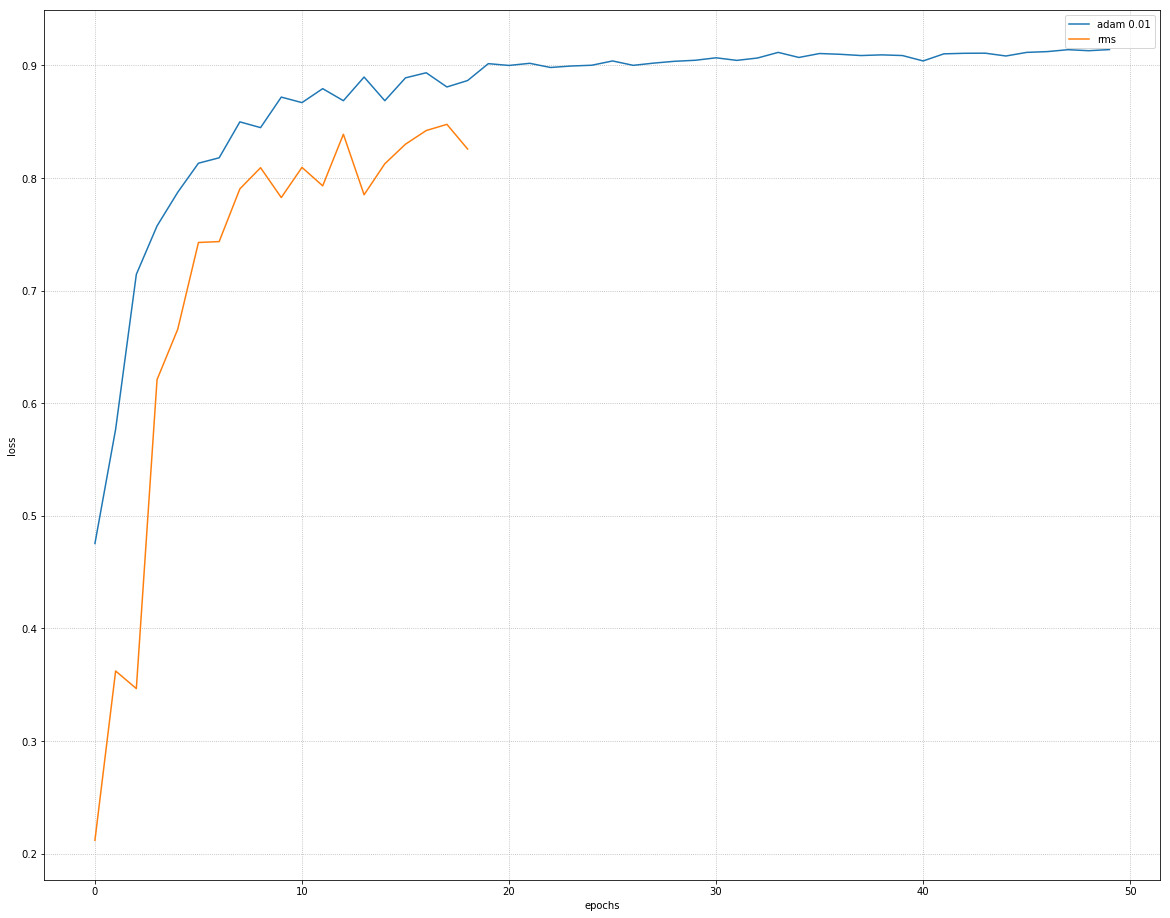

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# plt.plot(adam_test_acc)

plt.plot(adam_test_acc)

# plt.plot(eve_test_acc00)

plt.plot(rms_test_acc)


# plt.plot(eve_test_acc71)

plt.grid(ls=":")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["adam 0.01", "rms"])

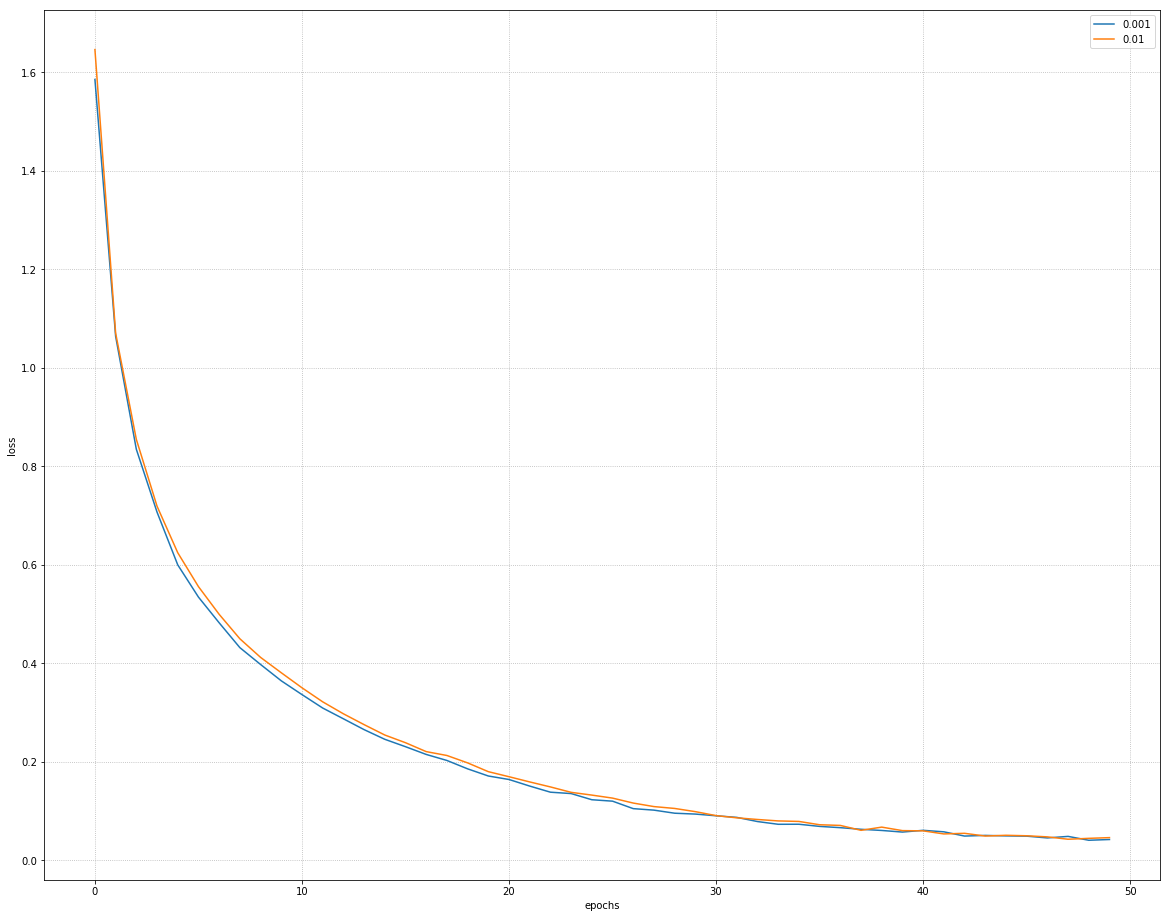

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.plot(adam_loss001)
plt.plot(adam_loss)

# plt.plot(eve_loss999_71[40:50])


# plt.plot(eve_test_lossno)

plt.grid(ls=":")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["0.001","0.01"])

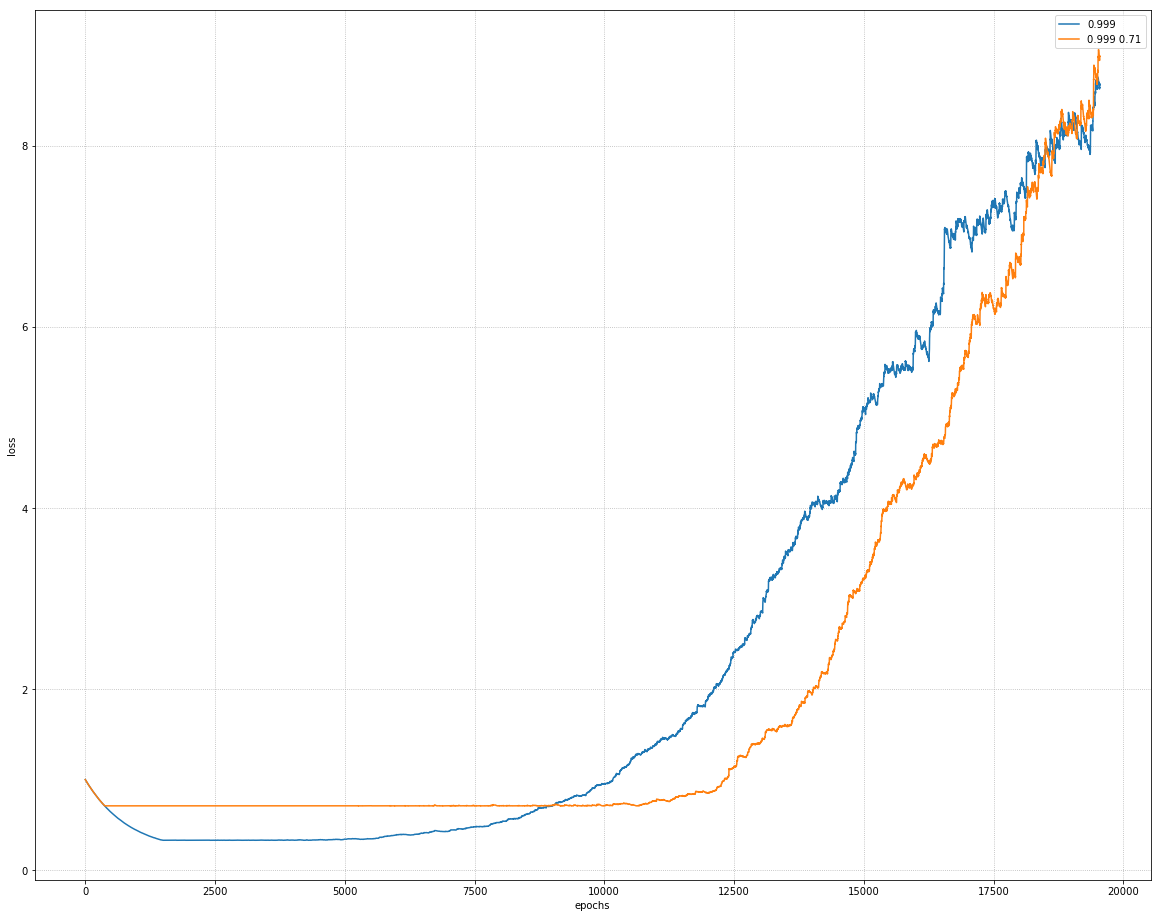

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# plt.plot(eve_test_accuracy)
# plt.plot(adam_ta)
# plt.plot(adam_test_accuracy1)

# plt.plot(eve_test_acc_no)

plt.plot(eve_dt999)

plt.plot(eve_dt999_71)
# plt.plot(eve_dt)



# plt.plot(eve_test_acc33)

# plt.plot(eve_test_acc)

plt.grid(ls=":")
plt.xlabel("epochs")
plt.ylabel("loss")



plt.legend(["0.999","0.999 0.71", "0.9"])






In [27]:
with open ("adam-loss-list-model-vgg16-0.001-0.0001.txt", 'rb') as fp:
    adam_loss_list = pickle.load(fp)

In [ ]:
ema = eve_loss_list[:]
lst_len = len(eve_loss_list)
for i in range(lst_len):
    ema[i] = 0.9 * eve_loss_list[i-1] + 0.1 * eve_loss_list[i]
    
    

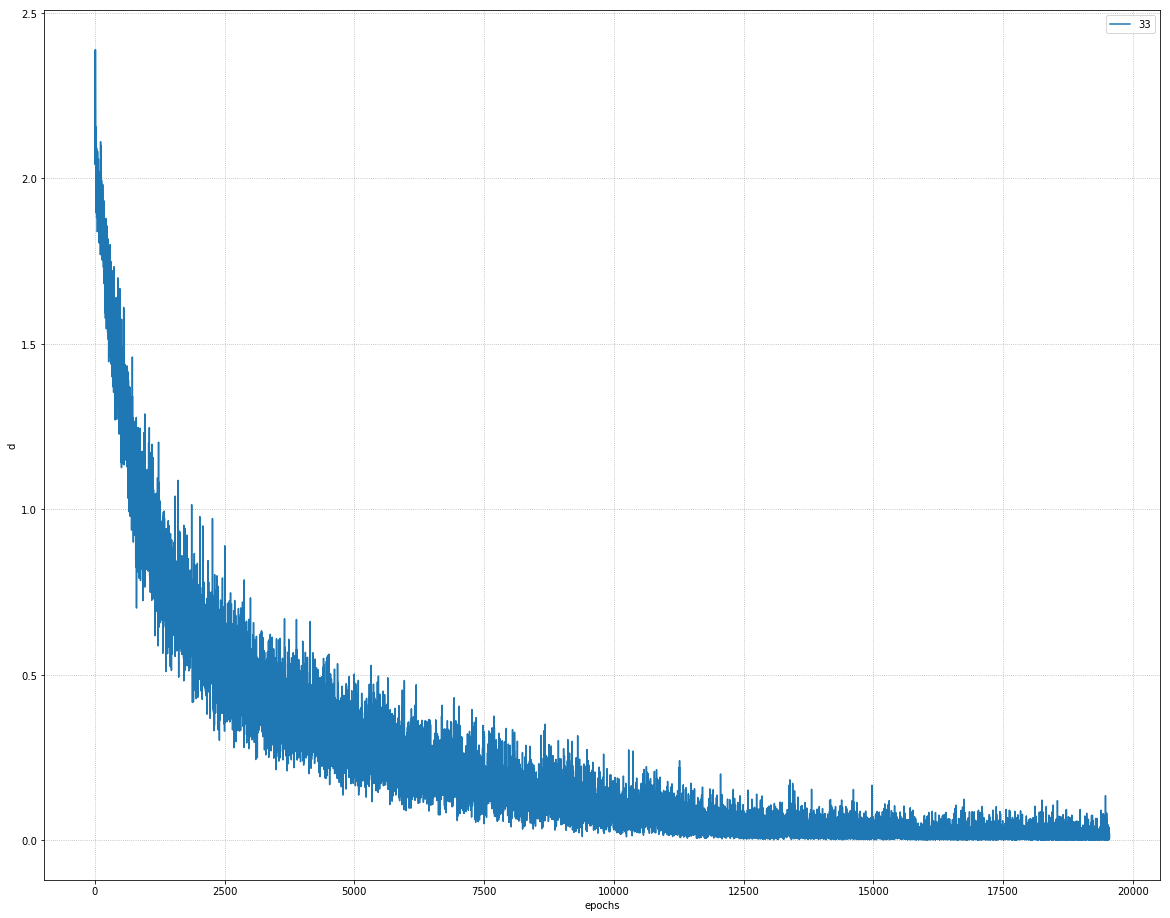

In [29]:
# plt.plot(eve_loss_list33)

plt.plot(eve_loss_list)


# plt.plot(eve_dt_nodecay)


# plt.plot(eve_test_acc_nodecay)

# plt.plot(eve_test_acc)
plt.grid(ls=":")
plt.xlabel("epochs")
plt.ylabel("d")



plt.legend(["33","71"])

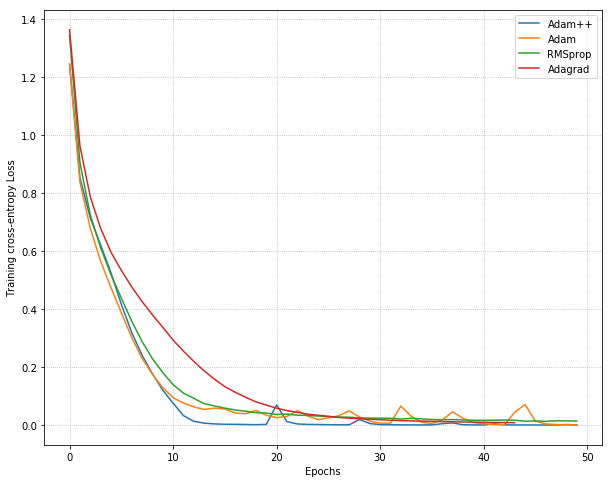

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# plt.plot(eve_test_accuracy)
# plt.plot(adam_ta)
# plt.plot(adam_test_accuracy1)

# plt.plot(eve_test_acc_no)

# plt.plot(eve_dt_no)

# plt.plot(eve_dt)



# plt.plot(eve_dt_none)

# plt.plot(adam_test_acc)

# plt.plot(eve_test_acc)


# plt.plot(adam_test_loss_nil)

# plt.plot(adam_loss00[40:49])
# plt.plot(eve_test_acc)
# plt.plot(adam_test_acc)

# plt.plot(rms_test_acc)


# plt.plot(eve_test_acc_nil)

# plt.plot(eve_loss01)


# plt.plot(eve_loss_nodecay)


plt.plot(eve_loss)

plt.plot(adam_loss)

plt.plot(rms_loss)

plt.plot(ada_loss)


# plt.plot(eve_test_acc)

# plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Training cross-entropy Loss")
plt.grid(ls=":")

plt.legend(["Adam++", "Adam", "RMSprop","Adagrad"])






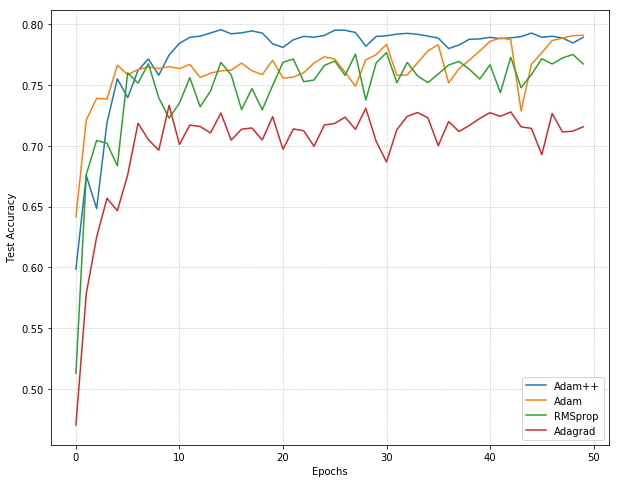

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# plt.plot(eve_test_accuracy)
# plt.plot(adam_ta)
# plt.plot(adam_test_accuracy1)

# plt.plot(eve_test_acc_no)

# plt.plot(eve_dt_no)

# plt.plot(eve_dt)



# plt.plot(eve_d_t6)

# plt.plot(adam_test_acc)

# plt.plot(eve_test_acc)


# plt.plot(adam_test_loss_nil)

# plt.plot(adam_loss00[40:49])
# plt.plot(eve_test_acc)
# plt.plot(adam_test_acc)

# plt.plot(rms_test_acc)


# plt.plot(eve_test_acc_nil)



# plt.plot(eve_test_acc_no)

plt.plot(eve_test_acc)

plt.plot(adam_test_acc)

plt.plot(rms_test_acc)

plt.plot(ada_test_acc)


plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.grid(ls=":")


plt.legend(["Adam++", "Adam", "RMSprop","Adagrad"])




